In [1]:
!pip install opencv-python pixellib

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 50.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 137.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 109.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 52.7 MB/s eta 0:00:0000:0100:01m
  DEPRECATION: Building 'fvcore' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517`

In [2]:
# cv2: OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
# torch: PyTorch. 딥러닝 및 텐서 연산을 위한 라이브러리. 인공지능 모델을 만들거나 불러와 추론하는 도구
# torchvision: 이미지 변환 및 전처리를 위한 torchvision의 transform 모듈
# deeplabv3_resnet101: 사전 학습된 DeepLabV3 모델. 이미지를 분류하도록 학습된 모델
# matplotlib: 파이썬 프로그래밍 언어 및 수학적 확장 NumPy 라이브러리를 활용한 플로팅 라이브러리로, 데이터 시각화 도구

import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

In [3]:
# 준비한 이미지 파일의 경로를 이용하여, 이미지 파일을 읽음
# cv2.imread(경로): 경로에 해당하는 이미지 파일을 읽어서 변수에 저장

home_dir = os.getenv('HOME')
img_path = os.path.join(home_dir, "work/human_segmentation/images/my_image.png")
img_orig = cv2.imread(img_path)

print(f"이미지 크기: {img_orig.shape}")

이미지 크기: (500, 892, 3)


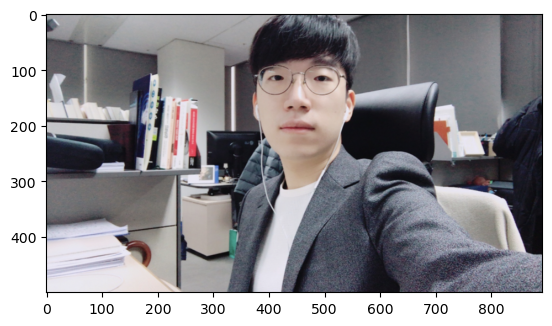

In [4]:
# cv2.cvtColor(입력이미지, 색상 변환 코드) : 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB : 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow() : 저장된 데이터를 이미지의 형식으로 표시
# plt.show() : 현재 열려있는 모든 figure를 표시

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## DeepLab 모델 준비

In [5]:
# DeepLab 모델 준비
model = deeplabv3_resnet101(pretrained=True).eval()

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /home/jovyan/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


100%|██████████| 233M/233M [00:03<00:00, 67.7MB/s] 


In [6]:
# 사전 학습된 모델은 모델의 전처리 방식과 입력 크기 등이 사전 학습에 사용한 것과 동일하게 사용해야함
transform = T.Compose([
    T.ToPILImage(),       # OpenCV나 numpy 배열 → PIL 이미지로 변환
    T.Resize((520, 520)), # 모델 입력 크기 (고정)
    T.ToTensor(),         # PIL 이미지 → PyTorch Tensor
                              # (픽셀값을 [0,255] → [0,1]로 정규화(H, W, C) → (C, H, W) 형태로 변경)
])

# DeepLab 계열 모델은 학습 시 특정 입력 크기(예: 513, 520 등)를 기준으로
# ASPP, stride, feature map 크기가 설계되어 있기 때문에
# 입력 크기가 다르면 receptive field 구조가 깨질 수 있다.

In [7]:
# 모델에 이미지 입히기(모델에 넣기 위한 입력을 만드는 단계)
input_tensor = transform(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)).unsqueeze(0)

In [8]:
# 모델에 이미지 입력

# %%time
with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()    # argmax(0) : 첫 번째 축을 기준으로 값이 가장 높은 순서(라벨) 출력

print(output_predictions)

# 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_NEAREST)

# interpolation=cv2.INTER_NEAREST : 사진 Resize 시 생기는 공백을 어떻게 채울 것인가..

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ... 15 15 15]
 [ 0  0  0 ... 15 15 15]
 [ 0  0  0 ... 15 15 15]]


In [9]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

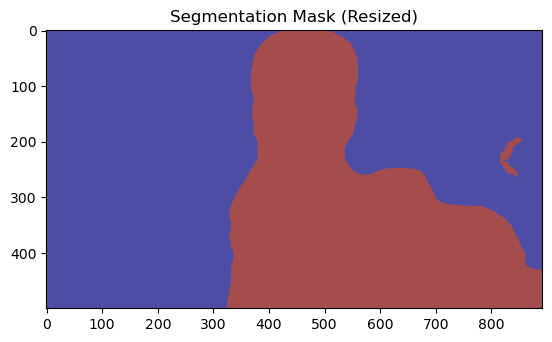

In [10]:
plt.imshow(output_predictions_resized, cmap="jet", alpha=0.7)
plt.title("Segmentation Mask (Resized)")
plt.show()

In [11]:
# 클래스 확인
unique_classes = np.unique(output_predictions_resized)
unique_classes

# 0번 : backgrounds
# 15번 : person
for class_id in unique_classes:
    print(LABEL_NAMES[class_id])

background
person


In [12]:
#컬러맵 만들기
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]  # 생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [13]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

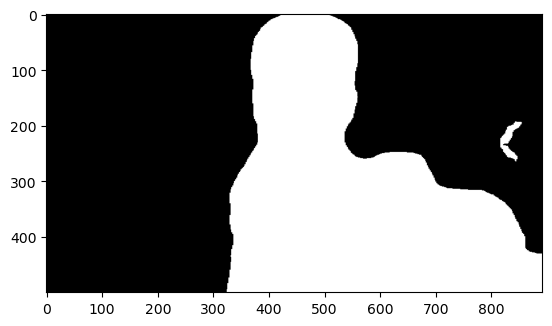

In [14]:
seg_map = (output_predictions_resized == 15)    # output의 픽셀 별로 예측된 class가 사람이면 1(True), 다르면 0(False)
img_mask = seg_map.astype(np.uint8) * 255       # 0 또는 255로 표현
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET) # cv2.COLORMAP_JET : 0 → 파랑 계열 / 255 → 빨강 계열

plt.imshow(img_mask, cmap='gray')
plt.show()

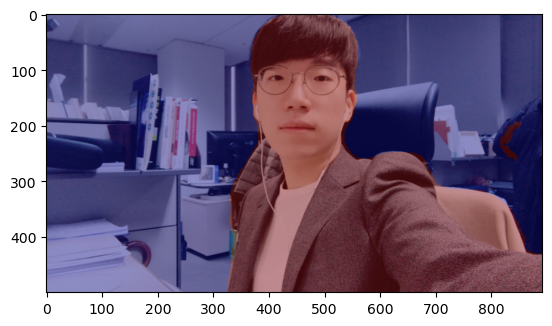

In [15]:
# 원본 이미지와 마스크 합치기
img_show = cv2.addWeighted(img_orig, 0.6, color_mask, 0.4, 0.0)

# img_orig : 원본 이미지
# 0.6 : 원본 이미지 비중
# color_mask : 컬러 마스크
# 0.4 : 마스크의 비중
# 0.0 : 밝기 보정용 상수 (여기선 사용 X)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 배경 흐리게 하기

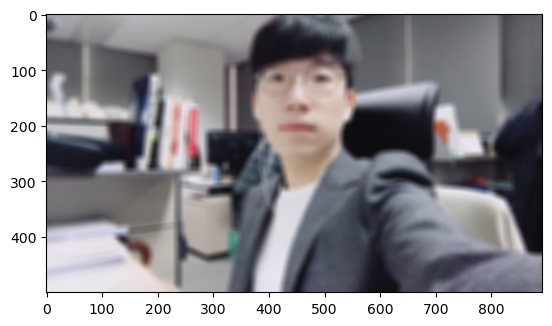

In [16]:
img_orig_blur = cv2.blur(img_orig, (13, 13))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

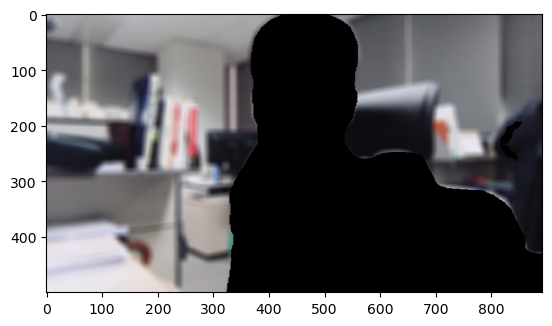

In [17]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) # cv2.bitwise_not() : 이미지 반전
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) # 사람이 있는 픽셀이 0이었기 때문에 연산 시 사람은 사라지고 배경만 남김

plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 흐린 배경과 원본 영상 합성

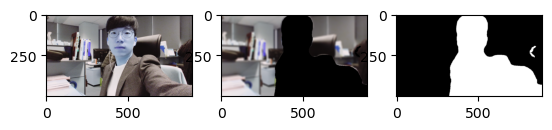

In [18]:
# 사용할 이미지 확인
plt.subplot(1,3,1)
plt.imshow(img_orig)
plt.subplot(1,3,2)
plt.imshow(img_bg_blur)
plt.subplot(1,3,3)
plt.imshow(img_mask_color)

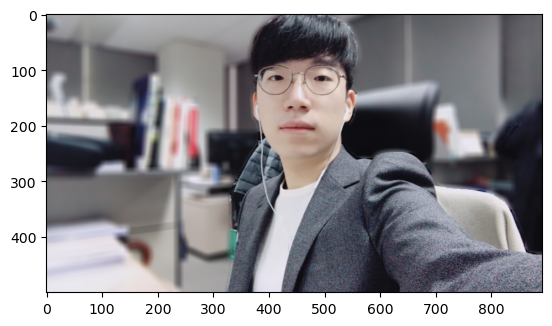

In [19]:
# 흐린 배경과 원본 영상 합성
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) 

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

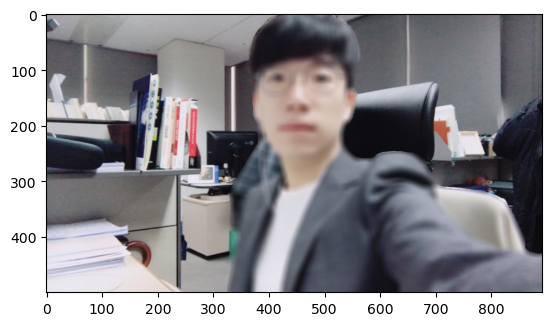

In [20]:
img_concat = np.where(img_mask_color == 255, img_orig_blur, img_orig)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 인물사진을 만들어보자

## 1. 인물 모드 문제점 찾기

In [21]:
# !pip install opencv-python pixellib

In [22]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

print(cv2.__version__)

4.11.0


원본 고양이 이미지 크기: (779, 1000, 3)
배경(사막) 이미지 크기: (1080, 1080, 3)


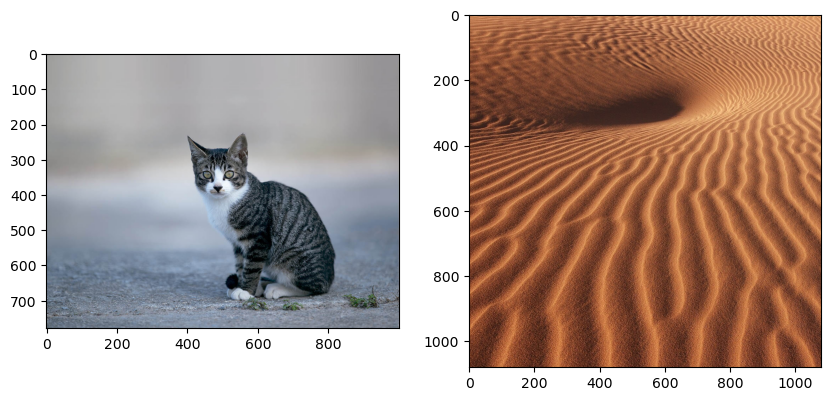

In [23]:
cat_img_path = "./images/cat.jpg"  # 고양이 이미지를 준비해주세요
sand_img_path = "./images/sand.jpg"  # 사막 배경 이미지를 준비해주세요

cat_img = cv2.imread(cat_img_path)
sand_img = cv2.imread(sand_img_path)

cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)
sand_img = cv2.cvtColor(sand_img, cv2.COLOR_BGR2RGB)

print(f"원본 고양이 이미지 크기: {cat_img.shape}")
print(f"배경(사막) 이미지 크기: {sand_img.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cat_img)

plt.subplot(1, 2, 2)
plt.imshow(sand_img)

plt.show()

In [24]:
model = deeplabv3_resnet101(pretrained=True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기
    T.ToTensor(),
])

input_tensor = transform(cat_img).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

추론 마스크 크기 (Before Resize): (520, 520)


In [25]:
# 마스크를 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (cat_img.shape[1], cat_img.shape[0]), interpolation=cv2.INTER_NEAREST)

print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

추론 마스크 크기 (After Resize): (779, 1000)


In [26]:
# 클래스 구분
unique_classes = np.unique(output_predictions_resized)
print(f"예측된 클래스 ID: {unique_classes}")

예측된 클래스 ID: [0 8]


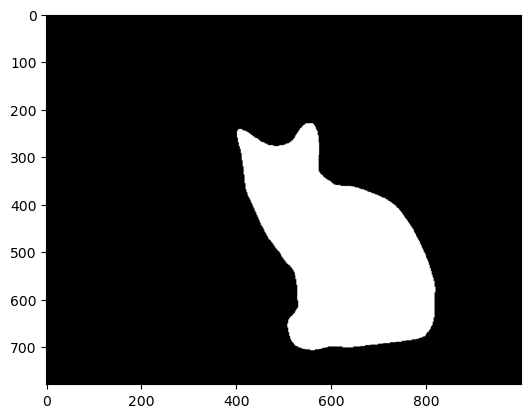

In [27]:
target_class_id = unique_classes[-1]

seg_map = (output_predictions_resized == target_class_id)
img_mask = seg_map.astype(np.uint8) * 255

plt.imshow(img_mask, cmap='gray')
plt.show()

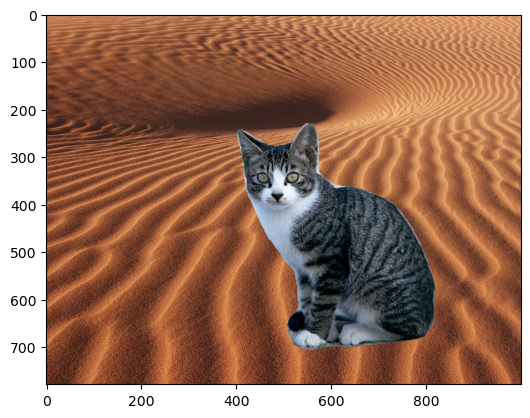

In [28]:
# 배경을 고양이 이미지 크기에 맞춤
sand_img_resized = cv2.resize(sand_img, (cat_img.shape[1], cat_img.shape[0]))

# 고양이 부분만 남기고 배경 적용
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img = np.where(img_mask_color == 255, cat_img, sand_img_resized)  # 마스크 기반 합성

plt.imshow(result_img)
plt.show()

## 2. 사진에서 문제점 찾기(프로젝트 제출)

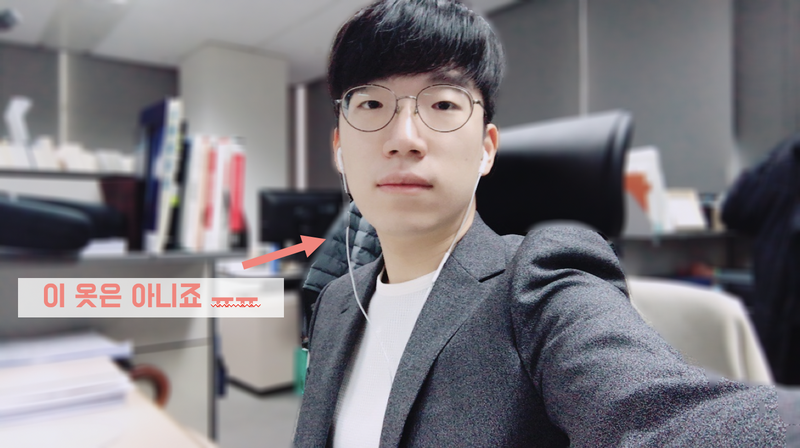

### **문제점**
1. '사람' 외에 다른 사물(패딩)이 사람으로 Segmentation 되는 경우가 있음
2. 깊이에 따라서 아웃포커싱이 잡혀야하는데, 단순 Segmentation을 통해서 포커싱이 잡힘(Depth 정보 부재 문제)
3. 사람의 신체 일부와 연결돼 있으나 떨어져 있는 사물(이어폰)이 배경으로 인식되어 블러 처리됨
4. 먼 사물일 수록 블러가 더욱 진하게 처리되어야 하는데 배경은 모두 같은 수준의 블러가 처리됨

### **해결방안**
1. 다른 종류의 사물을 더 학습시켜서 "사람"의 정의를 더 명확히 하는 방법
2. 이미지 혹은 카메라의 종류를 바꾸는 게 맞다고 생각됨. 각 픽셀에 대하여 depth 정보가 추가되어야할듯 ex) LiDAR, stereo camera...
3. 위 모델에서 쓰인 Atrous convolution 기법과 관련하여 receptive field를 더 확장하는 방향으로 해결할 수 있을 것 같음
4. 2번과 마찬가지로 깊이에 따른 블러처리 또한 Depth 데이터가 있으면 좋을 것으로 생각됨, 만약 없다면 Depth를 직접 학습시키는 방법도 존재하는 것으로 보임
    1. Supervised Depth Learning
       1. LiDAR, ToF 센서, 스테레오 카메라로 얻은 실제 depth를 정답으로 사용
       2. 정확도가 가장 높으나, Depth 정답 데이터 수집이 매우 비쌈
       3. 실외/실내 환경별로 데이터셋 구축 난이도 큼
    2. Self-supervised Depth Learning
       1. 예측된 Depth로 다른 시점 이미지를 재구성
       2. 재구성 오차를 Loss로 사용
       3. 참고논문 : https://arxiv.org/abs/1609.03677

In [51]:
# 아웃포커싱 함수 개발



# DeepLab 모델 준비
# model = deeplabv3_resnet101(pretrained=True).eval()

def my_outfocusing(img_orig, object_num, blur_size, model):
    # 사전 학습된 모델은 모델의 전처리 방식과 입력 크기 등이 사전 학습에 사용한 것과 동일하게 사용해야함
    transform = T.Compose([
        T.ToPILImage(),       # OpenCV나 numpy 배열 → PIL 이미지로 변환
        T.Resize((520, 520)), # 모델 입력 크기 (고정)
        T.ToTensor(),         # PIL 이미지 → PyTorch Tensor
                                  # (픽셀값을 [0,255] → [0,1]로 정규화(H, W, C) → (C, H, W) 형태로 변경)
    ])


    # 모델에 이미지 입히기(모델에 넣기 위한 입력을 만드는 단계)
    input_tensor = transform(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)).unsqueeze(0)

    
    # 모델에 이미지 입력
    # %%time
    with torch.no_grad():
        output = model(input_tensor)["out"][0]
        output_predictions = output.argmax(0).byte().cpu().numpy()    # argmax(0) : 첫 번째 축을 기준으로 값이 가장 높은 순서(라벨) 출력
    
    # print(output_predictions)
    
    # 원본 크기로 Resize
    output_predictions_resized = cv2.resize(output_predictions, (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_NEAREST)

    # 클래스 확인
    unique_classes = np.unique(output_predictions_resized)
    unique_classes

    # pascalvoc 데이터의 라벨종류
    LABEL_NAMES = [
       'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
       'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
       'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    ]
    
    # 0번 : backgrounds
    # 15번 : person
    # for class_id in unique_classes:
    #     print(LABEL_NAMES[class_id])

    # 배경 흐리게 하기
    img_orig_blur = cv2.blur(img_orig, (blur_size, blur_size))

    # 세그먼트 색깔 변경
    # seg_map = (output_predictions_resized == object_num)        # output의 픽셀 별로 예측된 class가 사람이면 1(True), 다르면 0(False)
    seg_map = np.isin(output_predictions_resized, object_num)     # 두 사물 이상 인지
    img_mask = seg_map.astype(np.uint8) * 255       # 0 또는 255로 표현
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET) # cv2.COLORMAP_JET : 0 → 파랑 계열 / 255 → 빨강 계열

    # 원본 이미지와 마스크 합치기
    img_show = cv2.addWeighted(img_orig, 0.6, color_mask, 0.4, 0.0)

    # 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color) # cv2.bitwise_not() : 이미지 반전
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) # 사람이 있는 픽셀이 0이었기 때문에 연산 시 사람은 사라지고 배경만 남김

    # 흐린 배경과 원본 영상 합성
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) 
    img_concat = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)

    
    return img_concat

## (프로젝트 제출) 인물사진 아웃포커싱

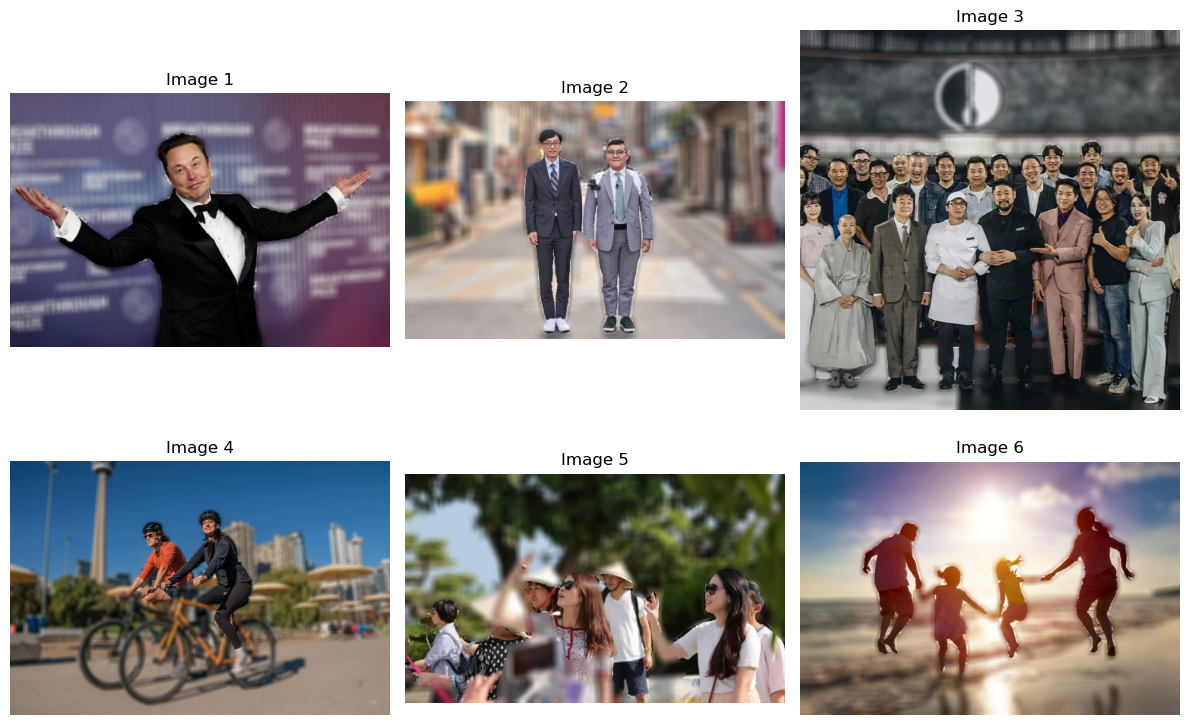

In [50]:
home_dir = os.getenv('HOME')
img_path_1 = os.path.join(home_dir, "work/human_segmentation/images/people_1.jpg")
img_path_2 = os.path.join(home_dir, "work/human_segmentation/images/people_2.jpg")
img_path_3 = os.path.join(home_dir, "work/human_segmentation/images/people_3.webp")
img_path_4 = os.path.join(home_dir, "work/human_segmentation/images/people_4.jpg")
img_path_5 = os.path.join(home_dir, "work/human_segmentation/images/people_5.jpg")
img_path_6 = os.path.join(home_dir, "work/human_segmentation/images/people_6.jpg")

img_orig_1 = cv2.imread(img_path_1)
img_orig_2 = cv2.imread(img_path_2)
img_orig_3 = cv2.imread(img_path_3)
img_orig_4 = cv2.imread(img_path_4)
img_orig_5 = cv2.imread(img_path_5)
img_orig_6 = cv2.imread(img_path_6)

target_object = 15        # 사람

img_concat_1 = my_outfocusing(img_orig_1, target_object, 13, model)
img_concat_2 = my_outfocusing(img_orig_2, target_object, 13, model)
img_concat_3 = my_outfocusing(img_orig_3, target_object, 13, model)
img_concat_4 = my_outfocusing(img_orig_4, target_object, 30, model)
img_concat_5 = my_outfocusing(img_orig_5, target_object, 13, model)
img_concat_6 = my_outfocusing(img_orig_6, target_object, 13, model)

img_list = [img_concat_1, img_concat_2, img_concat_3, img_concat_4, img_concat_5, img_concat_6]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(img_list[i])
    ax.set_title(f"Image {i+1}")   # 번호 붙이기
    ax.axis('off')

plt.tight_layout()
plt.show()

## **Image1 ~ Image3** : 한 명 ~ 여러 명
1. 사람 한 명 ~ 사람 여러 명 아웃포커싱 기능 확인
2. 사람 여러 명 겹쳐있더라도 잘 인식 하는 것 확인

## **Image4** : 라벨에 포함된 사람, 사물이 같이 있는 경우
1. 사람과 접촉한 사물도 배경과 같이 블러 처리됨
2. '자전거'의 경우 라벨에 포함된 사물이므로 두 가지 이상의 사물을 인지할 수 있도록 추가로 개발해봐야 할듯

## **Image5**
1. 학습 되지 않은 여러 사물들과 사람들이 뒤섞여 있는 경우 같이 블러처리 됨
2. 모자, 핸드폰 등의 사물을 추가적으로 학습시켜서 '사람'을 더 잘 정의할 수 있도록 해야할듯

## **Imgae6**
1. 역광 등으로 인해 사람이 그림자가 져있는 경우 사물의 경계를 잘 인지하지 못하는 것으로 보임
2. 손을 잡고 있는 부분이 블러 처리됨

-------

### Image4 : 두 가지 이상의 사물 인지
- ```seg_map = np.isin(output_predictions_resized, object_num)``` 코드 추가

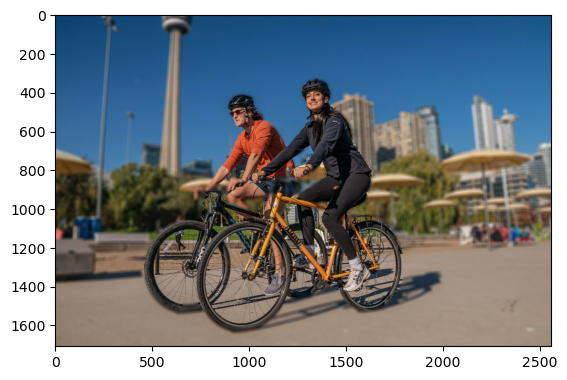

In [54]:
target_object_multi = [15, 2]
img_concat_4a = my_outfocusing(img_orig_4, target_object_multi, 20, model)
    
plt.imshow(img_concat_4a)
plt.show()

## 동물 사진 아웃포커싱

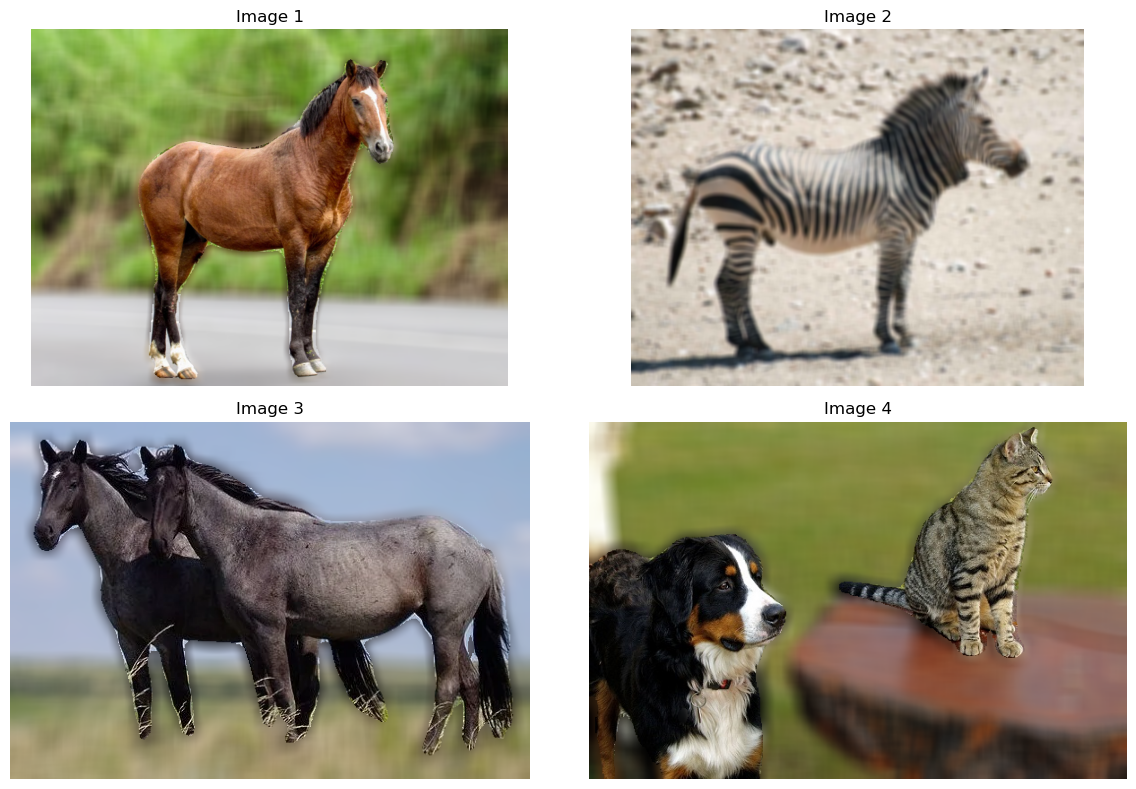

In [58]:
home_dir = os.getenv('HOME')
img_path_1 = os.path.join(home_dir, "work/human_segmentation/images/animal_1.jpg")
img_path_2 = os.path.join(home_dir, "work/human_segmentation/images/animal_2.jpg")
img_path_3 = os.path.join(home_dir, "work/human_segmentation/images/animal_3.webp")
img_path_4 = os.path.join(home_dir, "work/human_segmentation/images/animal_4.jpg")

img_orig_1 = cv2.imread(img_path_1)
img_orig_2 = cv2.imread(img_path_2)
img_orig_3 = cv2.imread(img_path_3)
img_orig_4 = cv2.imread(img_path_4)


target_object_a = 13        # 말
target_object_b = [8, 12]

img_concat_1 = my_outfocusing(img_orig_1, target_object_a, 21, model)
img_concat_2 = my_outfocusing(img_orig_2, target_object_a, 21, model)
img_concat_3 = my_outfocusing(img_orig_3, target_object_a, 21, model)
img_concat_4 = my_outfocusing(img_orig_4, target_object_b, 21, model)

img_list = [img_concat_1, img_concat_2, img_concat_3, img_concat_4]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(img_list[i])
    ax.set_title(f"Image {i+1}")   # 번호 붙이기
    ax.axis('off')

plt.tight_layout()
plt.show()

## Image2
- 얼룩말은 학습이 안 돼서 인식을 못하는 것 같음. 형태뿐만이 아니라 피부 색깔, 패턴도 인식에 영향을 주는 것 같음

## Image3-4
- 두 마리 동물, 서로 다른 동물 인식 잘 되는 것 확인

---------------------

## 배경 전환 크로마키

원본 사람 이미지 크기: (427, 640, 3)
배경(사막) 이미지 크기: (1080, 1080, 3)


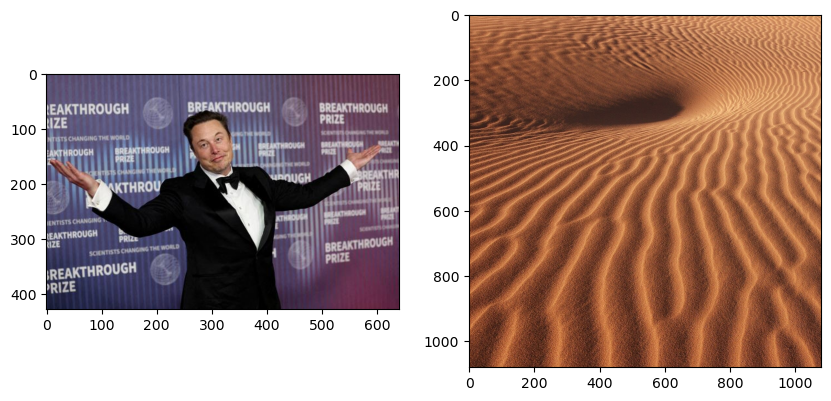

In [60]:
import os

home_dir = os.getenv('HOME')
person_img_path = os.path.join(home_dir, "work/human_segmentation/images/people_1.jpg")  # 고양이 이미지를 준비해주세요
sand_img_path = os.path.join(home_dir, "work/human_segmentation/images/sand.jpg")  # 사막 배경 이미지를 준비해주세요

person_img = cv2.imread(person_img_path)
sand_img = cv2.imread(sand_img_path)

person_img = cv2.cvtColor(person_img, cv2.COLOR_BGR2RGB)
sand_img = cv2.cvtColor(sand_img, cv2.COLOR_BGR2RGB)

print(f"원본 사람 이미지 크기: {person_img.shape}")
print(f"배경(사막) 이미지 크기: {sand_img.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(person_img)

plt.subplot(1, 2, 2)
plt.imshow(sand_img)

plt.show()

In [62]:
# model = deeplabv3_resnet101(pretrained=True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기
    T.ToTensor(),
])

input_tensor = transform(person_img).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

추론 마스크 크기 (Before Resize): (520, 520)


In [64]:
# 마스크를 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (person_img.shape[1], person_img.shape[0]), interpolation=cv2.INTER_NEAREST)

print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

추론 마스크 크기 (After Resize): (427, 640)


In [65]:
# 클래스 구분
unique_classes = np.unique(output_predictions_resized)
print(f"예측된 클래스 ID: {unique_classes}")

예측된 클래스 ID: [ 0 15]


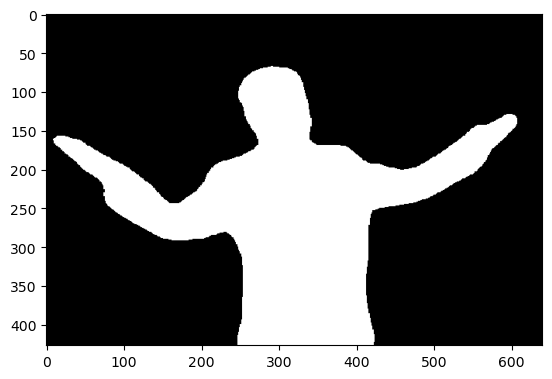

In [66]:
target_class_id = unique_classes[-1]

seg_map = (output_predictions_resized == target_class_id)
img_mask = seg_map.astype(np.uint8) * 255

plt.imshow(img_mask, cmap='gray')
plt.show()

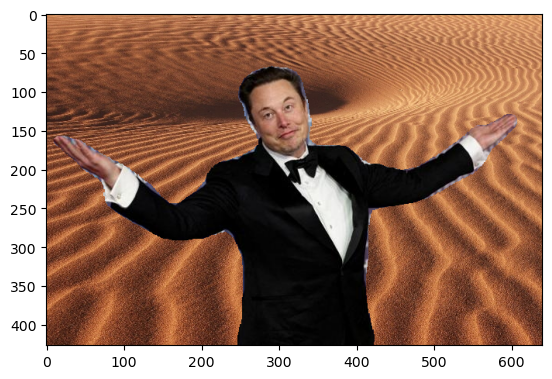

In [67]:
# 배경을 사람 이미지 크기에 맞춤
sand_img_resized = cv2.resize(sand_img, (person_img.shape[1], person_img.shape[0]))

# 사람 부분만 남기고 배경 적용
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img = np.where(img_mask_color == 255, person_img, sand_img_resized)  # 마스크 기반 합성

plt.imshow(result_img)
plt.show()